In [ ]:
import re
import json
import argparse
from os.path import exists
from glob import glob
from os.path import isdir
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import warnings
from nltk.tokenize import word_tokenize
warnings.simplefilter(action='ignore')
import spacy
from nltk.corpus import wordnet

In [ ]:
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.pipeline import Pipeline

In [ ]:
def load_dataset(file_name):
    import pandas as pd
    import json
    
    df = []
    with open(file_name) as f:
        for i in f:
            i = json.loads(i)
            tweet = i['postText']
            article_title = i['targetTitle']
            article = ' '.join(i['targetParagraphs'])
            label = i['tags']
            
            assert len(tweet) == 1
            tweet = tweet[0]
            
            assert len(label) == 1
            label = label[0]
            
            if label not in ['phrase', 'phrases', 'passage', 'multi']:
                print(label)
                
            assert label in ['phrase', 'phrases', 'passage', 'multi']
            
            if label == 'multi':
                continue
            
            df += [{'postText': i['postText'],
                    'targetParagraphs': i['targetParagraphs'],
                    'targetTitle': i['targetTitle'],
                    'targetDescription': i['targetDescription'],
                    'targetKeywords': i['targetKeywords'],
                    'spoiler': i['spoiler'],
                     'labels': (label == 'phrase' or label == 'phrases')}]

    return pd.DataFrame(df)   
            
train_dataset = load_dataset('/content/train.jsonl')
validation_dataset = load_dataset('/content/validation.jsonl')

In [ ]:
train_dataset

,postText,targetParagraphs,targetTitle,targetDescription,targetKeywords,spoiler,labels
0,"[Wes Welker Wanted Dinner With Tom Brady, But ...",[It’ll be just like old times this weekend for...,"Wes Welker Wanted Dinner With Tom Brady, But P...",It'll be just like old times this weekend for ...,"new england patriots, ricky doyle, top stories,",[how about that morning we go throw?],False
1,[NASA sets date for full recovery of ozone hole],[2070 is shaping up to be a great year for Mot...,Hole In Ozone Layer Expected To Make Full Reco...,2070 is shaping up to be a great year for Moth...,"ozone layer,ozone hole determined by weather,M...",[2070],True
2,[This is what makes employees happy -- and it'...,"[Despite common belief, money isn't the key to...",Intellectual Stimulation Trumps Money For Empl...,By: Chad Brooks \r\nPublished: 09/18/2013 06:4...,"employee happiness money,employee happiness in...",[intellectual stimulation],True
3,[The perfect way to cook rice so that it's per...,"[Boiling rice may seem simple, but there is a ...",Revealed: The perfect way to cook rice so that...,The question 'How does one cook rice properly?...,"Quora,users,share,perfect,way,cook,rice",[in a rice cooker],True
4,[What happens if your new AirPods get lost or ...,[One of the biggest surprise announcements at ...,Here's what happens if your Apple AirPods get ...,One of the first questions we had about Apple'...,None,[Apple says that if AirPods are lost or stolen...,False
...,...,...,...,...,...,...,...
2636,[If You See A Purple Butterfly Sticker At The ...,[If You See A Purple Butterfly Sticker At The ...,If You See A Purple Butterfly Sticker At The H...,Millie found out she was pregnant and she and ...,None,[one of her unborn twins had a condition calle...,False
2637,[Has Facebook's video explosion completely sha...,"[A long time ago in a galaxy far, far away...W...","Facebook Video Surging, But YouTube Still Offe...",.,"Facebook,web video,web video ads,YouTube",[it hasn’t necessarily taken the wind out of Y...,False
2638,[Cop Is Eating At A Chili's When Teen Hands Hi...,"[The Kansas City, Kansas Police Department are...",Cop is eating at Chili's when teen hands him f...,None,None,"[It read, ""Thanks for keeping us safe.""]",False
2639,[You need to see this Twitter account that pre...,"[What the HELL?!, 1. Unless you’re somewhere w...","WTF, It Looks Like This Twitter Account ""Predi...",,,[@beyoncefan666],True


In [ ]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2641 entries, 0 to 2640
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   postText           2641 non-null   object
 1   targetParagraphs   2641 non-null   object
 2   targetTitle        2641 non-null   object
 3   targetDescription  2415 non-null   object
 4   targetKeywords     1716 non-null   object
 5   spoiler            2641 non-null   object
 6   labels             2641 non-null   bool  
dtypes: bool(1), object(6)
memory usage: 126.5+ KB


In [ ]:
nlp = spacy.load('en_core_web_sm')
if not nlp.vocab:
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


In [ ]:
def lemmit(row):
  lemm_list = []
  for text in row['postText']:
    doc = nlp(text)
    for word in doc:
      if not word.is_punct and not word.is_stop:
        lemm_list.append(word.lemma_)
  return ' '.join(lemm_list)

In [ ]:
import re 
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
train_dataset['postText'] = train_dataset.apply(lemmit, axis=1)

In [ ]:
train_dataset

,postText,targetParagraphs,targetTitle,targetDescription,targetKeywords,spoiler,labels
0,Wes Welker want Dinner Tom Brady Patriots QB B...,[It’ll be just like old times this weekend for...,"Wes Welker Wanted Dinner With Tom Brady, But P...",It'll be just like old times this weekend for ...,"new england patriots, ricky doyle, top stories,",[how about that morning we go throw?],False
1,NASA set date recovery ozone hole,[2070 is shaping up to be a great year for Mot...,Hole In Ozone Layer Expected To Make Full Reco...,2070 is shaping up to be a great year for Moth...,"ozone layer,ozone hole determined by weather,M...",[2070],True
2,make employee happy paycheck,"[Despite common belief, money isn't the key to...",Intellectual Stimulation Trumps Money For Empl...,By: Chad Brooks \r\nPublished: 09/18/2013 06:4...,"employee happiness money,employee happiness in...",[intellectual stimulation],True
3,perfect way cook rice perfectly fluffy stick pan,"[Boiling rice may seem simple, but there is a ...",Revealed: The perfect way to cook rice so that...,The question 'How does one cook rice properly?...,"Quora,users,share,perfect,way,cook,rice",[in a rice cooker],True
4,happen new AirPods lose steal Apple,[One of the biggest surprise announcements at ...,Here's what happens if your Apple AirPods get ...,One of the first questions we had about Apple'...,None,[Apple says that if AirPods are lost or stolen...,False
...,...,...,...,...,...,...,...
2636,Purple Butterfly Sticker Hospital mean,[If You See A Purple Butterfly Sticker At The ...,If You See A Purple Butterfly Sticker At The H...,Millie found out she was pregnant and she and ...,None,[one of her unborn twins had a condition calle...,False
2637,Facebook video explosion completely shake ad m...,"[A long time ago in a galaxy far, far away...W...","Facebook Video Surging, But YouTube Still Offe...",.,"Facebook,web video,web video ads,YouTube",[it hasn’t necessarily taken the wind out of Y...,False
2638,cop eat Chili Teen hand Folded Napkin walk awa...,"[The Kansas City, Kansas Police Department are...",Cop is eating at Chili's when teen hands him f...,None,None,"[It read, ""Thanks for keeping us safe.""]",False
2639,need Twitter account predict Beyoncé pregnancy,"[What the HELL?!, 1. Unless you’re somewhere w...","WTF, It Looks Like This Twitter Account ""Predi...",,,[@beyoncefan666],True


In [ ]:
train_dataset.dropna(inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_dataset['labels'] = label_encoder.fit_transform(train_dataset['labels'])

In [ ]:
X_train,X_test,y_train,y_test= train_test_split(train_dataset.postText, train_dataset.labels,test_size=0.3,random_state=42)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = TfidfVectorizer().fit(X_train)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [ ]:
nb = MultinomialNB()
svm= SVC()
lr= LogisticRegression()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'C': np.logspace(-3, 3, 7),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 500, 1000]
} 

In [ ]:
kfold = KFold(n_splits=10,shuffle=True,random_state=0)
random_search = RandomizedSearchCV(lr, param_distributions=param_dist, n_iter=10, cv=kfold, scoring='f1_weighted', verbose=1, random_state=42)
random_search.fit(X_train,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
                   estimator=LogisticRegression(),
                   param_distributions={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'max_iter': [100, 500, 1000],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear', 'saga']},
                   random_state=42, scoring='f1_weighted', verbose=1)

In [ ]:
models = []
models.append(('Logistic Regression',lr))
models.append(('SVM',svm))
models.append(('Naive bayes',nb))

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10,shuffle=True,random_state=0)
    cv_results = cross_val_score(model,X_train,y_train,cv=kfold,scoring='f1_weighted')
    results.append(np.sqrt(np.abs(cv_results)))
    names.append(name)
    print("%s: %f (%f)" % (name, np.mean(cv_results),np.std(cv_results,ddof=1)))

Logistic Regression: 0.582800 (0.039986)
SVM: 0.550980 (0.052229)
Naive bayes: 0.580925 (0.043287)


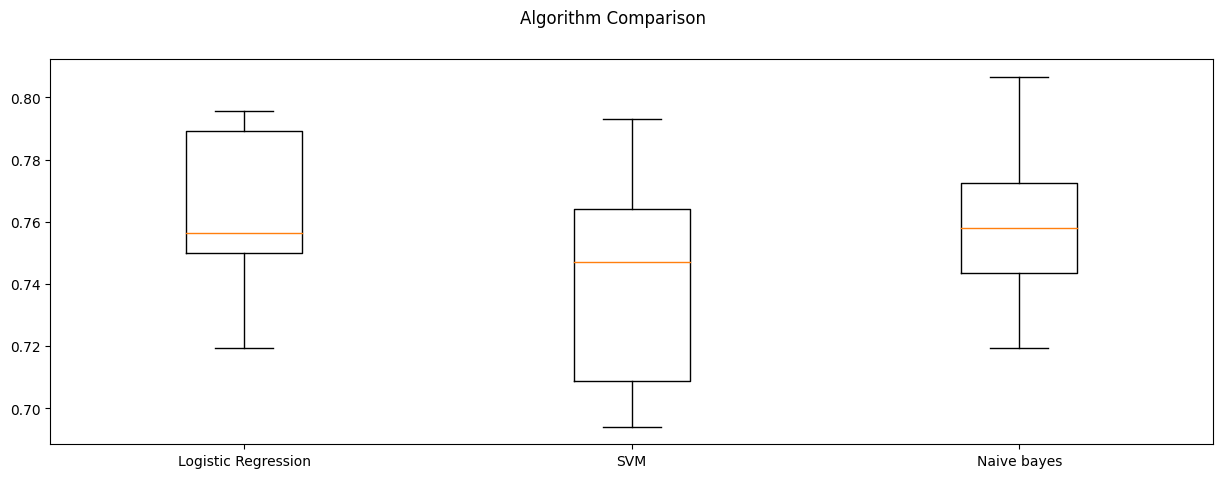

In [ ]:
fig = plt.figure(figsize=(15,5))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
#for one vs one classifier

lr_ovo = OneVsOneClassifier(lr)
lr_ovo.fit(X_train,y_train)




svm_ovo = OneVsOneClassifier(svm)
svm_ovo.fit(X_train,y_train)


nb_ovo = OneVsOneClassifier(nb)
nb_ovo.fit(X_train, y_train)


OneVsOneClassifier(estimator=MultinomialNB())

In [ ]:
validation_dataset = load_dataset('/content/validation.jsonl')
validation_dataset['postText'] = validation_dataset.apply(lemmit, axis=1)
validation_dataset['labels'] = label_encoder.transform(validation_dataset['labels'])
X_val = validation_dataset['postText']
Y_val = validation_dataset['labels']
X_val = vectorizer.transform(X_val)
val_lr_ovo_pred = lr_ovo.predict(X_val)

In [ ]:
print("one vs one logistic regression ")
print(classification_report(Y_val,val_lr_ovo_pred))

one vs one logistic regression 
              precision    recall  f1-score   support

           0       0.62      0.41      0.50       322
           1       0.57      0.76      0.65       335

    accuracy                           0.59       657
   macro avg       0.60      0.59      0.58       657
weighted avg       0.60      0.59      0.58       657



In [ ]:
val_svm_ovo_pred = svm_ovo.predict(X_val)
print("one vs one SVM ")
print(classification_report(Y_val,val_svm_ovo_pred))

one vs one SVM 
              precision    recall  f1-score   support

           0       0.66      0.38      0.48       322
           1       0.58      0.81      0.67       335

    accuracy                           0.60       657
   macro avg       0.62      0.60      0.58       657
weighted avg       0.62      0.60      0.58       657



In [ ]:
val_nb_ovo_pred = nb_ovo.predict(X_val)
print("one vs one nb ")
print(classification_report(Y_val,val_nb_ovo_pred))

one vs one nb 
              precision    recall  f1-score   support

           0       0.61      0.36      0.46       322
           1       0.56      0.78      0.65       335

    accuracy                           0.57       657
   macro avg       0.58      0.57      0.55       657
weighted avg       0.58      0.57      0.55       657

